# 🥱 LangGraph 深入理解工具呼叫（Function Calling）

在人工智慧和自然語言處理的領域中，工具呼叫（Function Calling）是一項革命性的技術。它賦予了大型語言模型（LLM）與外部資源互動的能力，大幅擴展了 AI 系統的功能範疇。本文將深入探討 LangGraph 框架中的工具呼叫機制，為您揭示其運作原理和實際應用。


❤️ Created by [hengshiousheu](https://huggingface.co/Heng666).


#0.環境建置

在開始我們的探索之前，讓我們先搭建實驗環境。

## 安裝套件包

在深入之前，我們需要先搭建實驗環境。

以下是所需的套件安裝命令：

In [ ]:
%%capture --no-stderr
%pip install --quiet langchain
%pip install --quiet langchain-openai
%pip install --quiet langgraph
%pip install --quiet tavily-python
%pip install --quiet langchain_community

In [ ]:
import os
import getpass
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')
os.environ["TAVILY_API_KEY"] = userdata.get('TAVILY_API_KEY')

In [ ]:
%pip show langgraph

Name: langgraph
Version: 0.2.15
Summary: Building stateful, multi-actor applications with LLMs
Home-page: https://www.github.com/langchain-ai/langgraph
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: langchain-core, langgraph-checkpoint
Required-by: 


> 💡 專業提示：確保所有環境變數都正確設置，這是順利執行後續程式碼的關鍵。建議使用環境變數或安全的密鑰管理系統來存儲 API 密鑰，而不是直接將它們寫入程式碼中。

# 1.何謂工具呼叫 Function Calling ?

工具呼叫允許大型語言模型（LLM）在生成對話過程中與外部工具互動。這意味著 LLM 可以存取超出其知識庫範圍的資訊或執行相應操作。工具可以是開發者編寫的函式、外部服務的 API，或任何 LLM 可以互動的資源。這項技術大大擴展了 LLM 的能力，使其不再侷限於訓練時獲得的靜態知識，而能夠動態地獲取資訊或執行特定任務。

想像一下，如果 LLM 能夠在對話中查詢即時天氣、進行複雜計算，甚至控制智慧家居設備，這將會帶來多麼驚人的可能性。工具呼叫正是實現這些功能的關鍵。

## 1.1 關鍵特性

- 動態互動：LLM 可以根據對話內容決定何時使用哪些工具。
- 能力擴展：通過外部工具，LLM 可以執行原本無法完成的任務。
- 靈活性：開發者可以自定義工具，以滿足特定需求。

## 1.2 工具呼叫的實際應用範例

讓我們通過一個簡單的天氣查詢工具來展現 Function calling 的實現過程：

In [ ]:
from langchain_core.tools import tool
from typing import Optional
from langchain_core.messages import AIMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langgraph.graph import END, MessagesState, StateGraph
from typing import Literal

@tool
def query_taiwan_weather(city: str, date: Optional[str] = None) -> str:
    """
    查詢台灣特定城市的天氣情況。

    參數:
    city (str): 要查詢天氣的城市名稱，例如 "台北"、"高雄" 等。
    date (str, 可選): 要查詢的日期，格式為 "YYYY-MM-DD"。如果不提供，則查詢當天天氣。

    返回:
    str: 包含天氣信息的字符串。
    """
    # 這裡應該是實際的天氣 API 調用邏輯
    # 為了示例，我們返回一個模擬的結果
    return f"{city} 在 {date or '今天'} 的天氣晴朗，溫度 25°C，適合外出活動。"

# LLM 處理邏輯（簡化示例）
llm = ChatOpenAI(model="gpt-3.5-turbo-0125")
llm_with_weather = llm.bind_tools([query_taiwan_weather])
response = llm_with_weather.invoke("請告訴我台北明天的天氣如何？")

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_vvtcALECQrfWPIiORXe1CWSy', 'function': {'arguments': '{"city":"台北","date":"2022-12-29"}', 'name': 'query_taiwan_weather'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 187, 'total_tokens': 214}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d9a8e1b8-219c-40bc-a4ca-557daa2b4c96-0', tool_calls=[{'name': 'query_taiwan_weather', 'args': {'city': '台北', 'date': '2022-12-29'}, 'id': 'call_vvtcALECQrfWPIiORXe1CWSy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 187, 'output_tokens': 27, 'total_tokens': 214})

在這個範例中，我們定義了一個簡單的 `query_taiwan_weather` 函式作為工具，然後將其加入工具列表。LLM 在處理用戶詢問時，決定使用這個工具來獲取即時天氣資訊，並將結果整合到回應中。

## 1.3 工具呼叫的限制與注意事項

- 並非所有 LLM 都支援工具呼叫功能，使用前請查閱特定模型的文檔。
- 工具的設計和實現需要考慮安全性和效能問題。
- 像 LangChain 這樣的框架提供了豐富的工具和功能，可以大大簡化 LLM 與工具之間的通訊過程。

# 2.LangGraph 中的 Tool Node 實作：打造智能工作流

##2.1 Tool Node 的概念與重要性

Tool Node 是 LangChain 中的一個關鍵組件，它作為一個可執行的節點，接收圖狀態（包含消息列表）作為輸入，並輸出更新後的狀態，其中包含工具調用的結果。Tool Node 的設計理念是：

- 與 LangGraph 的 prebuilt [ReAct agent](https://langchain-ai.github.io/langgraph/how-tos/create-react-agent/) 無縫協作
- 靈活適應任何具有 messages 鍵的 StateGraph(例如 [MessageState](https://github.com/langchain-ai/langgraph/blob/e3ef9adac7395e5c0943c22bbc8a4a856b103aa3/libs/langgraph/langgraph/graph/message.py#L150))

## 2.2 為什麼需要使用 Tool Node?

在複雜的 AI 系統中，Agent 通常由多個節點組成，包括：

- 呼叫 LLM 的節點
- 執行工具的節點
- 其他特定功能的節點

LLM 本身無法直接執行工具，它只能建議工具呼叫或給出對話回應。Tool Node 的作用就是橋接 LLM 的建議和實際的工具執行。

## 2.3 Tool Node 的實戰應用：天氣查詢 Agent

讓我們通過一個實際的例子來了解 Tool Node 的運作機制：


### 步驟ㄧ、導入所需要的 library

In [ ]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langgraph.graph import END, MessagesState, StateGraph
from typing import Literal

### 步驟二、定義好模型以及 Tool Node

In [ ]:
@tool
def get_taiwan_weather(city: str) -> str:
    """查詢台灣特定城市的天氣狀況。"""
    weather_data = {
        "台北": "晴天，溫度28°C",
        "台中": "多雲，溫度26°C",
        "高雄": "陰天，溫度30°C"
    }
    return f"{city}的天氣：{weather_data.get(city, '暫無資料')}"

tools = [get_taiwan_weather]
tool_node = ToolNode(tools)

model = ChatOpenAI()
model_with_tools = model.bind_tools(tools)

### 步驟三、定義好流程控制函數

In [ ]:
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END

def call_model(state: MessagesState):
    messages = state["messages"]
    response = model.invoke(messages)
    return {"messages": [response]}

### 步驟四、建立與配置圖

In [ ]:
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)
workflow.set_entry_point("agent")
workflow.add_conditional_edges("agent", should_continue)
workflow.add_edge("tools", "agent")

graph = workflow.compile()

### 步驟五、可視化整張圖

如果你想視覺化圖結構，可以使用以下程式碼：

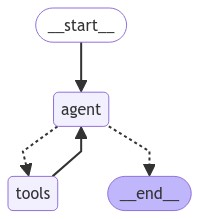

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 步驟六、與 Agent 互動

In [ ]:
user_input = "高雄天氣如何?"
events = graph.stream(
    {"messages": [("user", user_input)]},
    stream_mode="values"
    )
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

高雄天氣如何?
================================== Ai Message ==================================

我無法即時提供最新的天氣資訊，建議您可以透過天氣預報網站或氣象App查詢高雄的即時天氣情況。通常您可以查詢當日的氣溫、降雨機率、風向風速等相關資訊。希望這可以幫助到您。


## 2.4 工作流程解析

1. 初始化模型（ChatOpenAI）和工具（get_taiwan_weather）。
2. 創建一個 StateGraph，使用 MessagesState 管理對話消息列表。
3. 定義兩個關鍵節點：「agent」（LLM）和「tools」（執行動作）。
4. 設置圖的流程：
  - 以 agent 節點為入口點。
  - agent 節點後使用條件邊來決定是執行工具還是結束對話。
  - 執行工具後總是返回 agent 節點。

5. 編譯圖並可選擇視覺化其結構。
6. 當我們使用用戶輸入調用圖時，LangGraph：
  - 將輸入消息添加到狀態中。
  - 將狀態傳遞給 agent 節點。
  - 根據需要在 agent 和 tools 節點之間循環。
  - 當 agent 不再請求任何工具調用時，返回最終狀態。

> 💡 專業提示：這個範例展示了 LangGraph 的核心特性：狀態化對話、工具使用以及與各種 LLM 提供商和外部工具的無縫集成。在實際應用中，你可以根據需求擴展這個基本框架，添加更多複雜的工具和決策邏輯。

#3.Tool Node 的內部機制剖析

讓我們來瞅瞅 [ToolNode 內部運作原理](https://github.com/langchain-ai/langgraph/blob/b4d815e32a032ecc8093e4def15486bf1a88eb3e/libs/langgraph/langgraph/prebuilt/tool_node.py#L24C1-L24C34)

出自 ToolNode 程式碼註解

```python
"""A node that runs the tools requested in the last AIMessage. It can be used
    either in StateGraph with a "messages" key or in MessageGraph. If multiple
    tool calls are requested, they will be run in parallel. The output will be
    a list of ToolMessages, one for each tool call.

    The `ToolNode` is roughly analogous to:

    ```python
    tools_by_name = {tool.name: tool for tool in tools}
    def tool_node(state: dict):
        result = []
        for tool_call in state["messages"][-1].tool_calls:
            tool = tools_by_name[tool_call["name"]]
            observation = tool.invoke(tool_call["args"])
            result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
        return {"messages": result}
    ```

    Important:
        - The state MUST contain a list of messages.
        - The last message MUST be an `AIMessage`.
        - The `AIMessage` MUST have `tool_calls` populated.
    """
```

## 3.1 ToolNode 的核心功能

1. 執行最後一個 AIMessage 中請求的工具：ToolNode 專注於處理對話中最後一條 AI 消息中的工具調用請求。
2. 支持多種圖結構：它可以在帶有 "messages" 鍵的 StateGraph 類或 MessageGraph 類中使用。
3. 並行執行：當有多個工具調用請求時，ToolNode 會並行執行它們，提高效率。
4. 標準化輸出：輸出是一個 ToolMessage 列表，每個 ToolMessage 對應一個工具調用。

## 3.2 ToolNode 的工作流程
ToolNode 的內部邏輯大致如下：
```python
tools_by_name = {tool.name: tool for tool in tools}
def tool_node(state: dict):
    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}
```

這段程式碼展示了 ToolNode 的核心功能：
- 從狀態中提取最後一條消息的工具調用。
- 查找並執行相應的工具。
- 將結果包裝成 ToolMessage 並返回。

## 3.3 使用 ToolNode 的注意事項
- 狀態必須包含消息列表。
- 最後一條消息必須是 AIMessage。
- AIMessage 必須包含 tool_calls 字段。

# 4.如何處理 Function Calling 發生錯誤時？

在構建基於大型語言模型(LLMs)的 AI 系統時,我們經常會遇到一個關鍵挑戰：LLM 在調用工具時並不總是完美的。本文將深入探討這個問題,並提供一些實用的策略來增強系統的魯棒性。


## 4.1 LLM 在工具調用時可能出現的問題主要包括：

- 調用不存在的工具：LLM 可能會嘗試調用系統中並不存在的工具。
- 參數不匹配：返回的參數可能與工具所要求的模式(schema)不匹配。
- 邏輯錯誤：雖然語法正確,但 LLM 可能在邏輯上錯誤地使用工具。

常見緩解策略

- 簡化模式(Schema)：保持工具的輸入模式簡單明了,減少 LLM 出錯的可能性。
- 減少同時傳遞的工具數量：限制 LLM 一次可以訪問的工具數量,降低複雜度。
- 提供清晰的名稱和描述：為工具提供直觀的名稱和詳細的描述,幫助 LLM 正確理解和使用工具。

## 4.1 來看看失敗得案例


![上失敗的圖]()

In [ ]:
user_input = "高雄天氣如何?"
events = graph.stream({"messages": [("user", user_input)]}, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

高雄天氣如何?
================================== Ai Message ==================================

很抱歉，我無法提供即時的天氣資訊。您可以透過天氣預報網站或氣象APP查詢高雄的天氣情況。


## 4.2 嘗試策略ㄧ、添加 recursion_limit 次數，增加執行機會

主要方法是在 trigger graph 時候添加 config，參數為 recursion_limit，用法是在 cycle 超過次數限制時可以跳脫。

In [ ]:
user_input = "高雄天氣如何?"
events = graph.stream({"messages": [("user", user_input)]}, config={"recursion_limit": 100}, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

高雄天氣如何?
================================== Ai Message ==================================

很抱歉，我無法即時提供高雄的天氣資訊。您可以透過氣象局的網站或者氣象App查詢最新的天氣情況。希望這能幫助到您。如果您有其他問題，也歡迎向我提出。谢谢!


但我們的狀況很明顯還不夠處理，需要另尋他路。

## 4.3 策略二、不用 ToolNode，改成自行建立 fallbacks 機制

先讓我們手動調用以及測試 tool 是否建立成功

In [ ]:
@tool
def get_taiwan_weather(city: str) -> str:
    """查詢台灣特定城市的天氣狀況。"""
    weather_data = {
        "台北": "晴天，溫度28°C",
        "台中": "多雲，溫度26°C",
        "高雄": "陰天，溫度30°C"
    }
    return f"{city}的天氣：{weather_data.get(city, '暫無資料')}"

# 使用這個工具
result = get_taiwan_weather.run("台北")
print(f"呼叫工具結果{result}")

呼叫工具結果台北的天氣：晴天，溫度28°C


我們也使用自訂建置的節點來呼叫我們的工具，而不是預先建置的ToolNode ：

### 步驟一、定義好模型以及 Tool

在这个部分，我们定义了一个名为get_taiwan_weather的工具函数，它用于查询台湾特定城市的天气状况。这个函数使用了一个简单的字典来模拟天气数据，并在城市不存在时抛出一个ValueError异常。

In [ ]:
@tool
def get_taiwan_weather(city: str) -> str:
    """查詢台灣特定城市的天氣狀況。"""
    weather_data = {
        "台北": "晴天，溫度28°C",
        "台中": "多雲，溫度26°C",
        "高雄": "陰天，溫度30°C"
    }
    if city not in weather_data:
        raise ValueError(f"抱歉，目前無法取得{city}的天氣資訊")
    return f"{city}的天氣：{weather_data[city]}"

tools = [get_taiwan_weather]

model = ChatOpenAI(model="gpt-3.5-turbo")
model_with_tools = model.bind_tools(tools)

better_model = ChatOpenAI(model="gpt-4")
better_model_with_tools = better_model.bind_tools(tools)

我們還使用了兩個不同的 ChatOpenAI 模型：gpt-3.5-turbo 作為基礎模型,gpt-4 作為進階模型。這兩個模型都通過 bind_tools 方法與天氣查詢工具綁定,使得模型能夠在對話過程中調用該工具。


### 步驟二、定義流程控制函數

系統定義了幾個關鍵的流程控制函數：

1. should_continue: 這個函數決定是否需要繼續執行工具或結束對話。
2. should_fallback: 這個函數檢查是否有工具呼叫失敗，如果有，就決定是否需要切換到更強大的模型。
3. call_model: 負責呼叫語言模型產生回應。
4. call_tool: 負責執行工具調用，並處理可能出現的錯誤。
5. remove_failed_tool_call_attempt: 如果工具呼叫失敗，這個函數會從對話歷史中移除失敗的嘗試。
6. call_fallback_model: 如果需要，這個函數會呼叫更強大的模型（GPT-4）作為回退策略。

這些函數共同構建了系統的邏輯流程,實現了錯誤處理和模型回退等高級功能。

In [ ]:
import json
from langchain_core.messages import AIMessage, ToolMessage
from langchain_core.messages.modifier import RemoveMessage


def should_continue(state) -> Literal["tools", "end"]:
    """決定是否繼續執行工具或結束對話。"""
    messages = state["messages"]
    last_message = messages[-1]
    if isinstance(last_message, AIMessage) and last_message.tool_calls:
        return "tools"
    return END

def should_fallback(state) -> Literal["remove_failed_tool_call_attempt", "agent"]:
    """決定是否需要改用更厲害的模型。"""
    messages = state["messages"]
    failed_tool_messages = [
        msg for msg in messages
        if isinstance(msg, ToolMessage) and msg.additional_kwargs.get("error") is not None
    ]
    if failed_tool_messages:
        return "remove_failed_tool_call_attempt"
    return "agent"


def call_model(state):
    """呼叫模型產生回覆。"""
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

def call_tool(state):
    """執行工具呼叫。"""
    tools_by_name = {get_taiwan_weather.name: get_taiwan_weather}
    messages = state["messages"]
    last_message = messages[-1]
    output_messages = []
    for tool_call in last_message.tool_calls:
        try:
            tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"]['city'])
            output_messages.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        except Exception as e:
            output_messages.append(
                ToolMessage(
                    content="",
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                    additional_kwargs={"error": str(e)},
                )
            )
    return {"messages": output_messages}

def remove_failed_tool_call_attempt(state):
    """移除失敗的工具呼叫嘗試。"""
    messages = state["messages"]
    last_ai_message_index = next(
        i for i, msg in reversed(list(enumerate(messages)))
        if isinstance(msg, AIMessage)
    )
    messages_to_remove = messages[last_ai_message_index:]
    return {"messages": [RemoveMessage(id=m.id) for m in messages_to_remove]}

def call_fallback_model(state):
    """呼叫更厲害的模型作為備用策略。"""
    messages = state["messages"]
    response = better_model_with_tools.invoke(messages)
    return {"messages": [response]}


### 步驟三、建立與配置圖

我們使用StateGraph來建立對話流程圖。我們加入了各個節點（agent、tools、remove_failed_tool_call_attempt、fallback_agent），並定義了它們之間的連接和條件。

In [ ]:
workflow = StateGraph(MessagesState)
workflow.add_node("agent", call_model)
workflow.add_node("tools", call_tool)
workflow.add_node("remove_failed_tool_call_attempt", remove_failed_tool_call_attempt)
workflow.add_node("fallback_agent", call_fallback_model)

workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
    {
        "tools": "tools",
        END: END,
    },
)
workflow.add_conditional_edges(
    "tools",
    should_fallback,
    {
        "agent": "agent",
        "remove_failed_tool_call_attempt": "remove_failed_tool_call_attempt",
    },
)
workflow.add_edge("remove_failed_tool_call_attempt", "fallback_agent")
workflow.add_edge("fallback_agent", "tools")

graph = workflow.compile()

圖的工作流程如下：

1. 從"agent"節點開始，呼叫基礎模型產生回應。
2. 如果模型決定呼叫工具，流程會轉到"tools"節點。
3. 如果工具呼叫成功，流程會回到"agent"節點。
4. 如果工具呼叫失敗，流程會轉到"remove_failed_tool_call_attempt"節點，移除失敗的嘗試。
5. 然後，流程會轉到"fallback_agent"節點，使用更強大的模型重試。
6. 最後，流程會回到"tools"節點，嘗試再次執行工具呼叫。

這種設計允許系統在遇到問題時自動進行調整和重試，提高了系統的穩健性和回應品質。

### 步驟四、視覺化整張圖

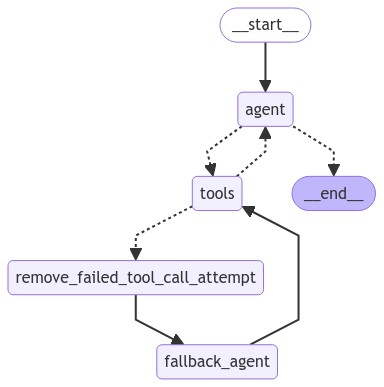

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

### 步驟五、與圖互通

這將模擬一個查詢高雄天氣的對話，並展示整個過程，包括可能的失敗處理和模型切換。

In [ ]:
user_input = "高雄天氣如何?"
events = graph.stream({"messages": [("user", user_input)]}, config={"recursion_limit": 10}, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

高雄天氣如何?
================================== Ai Message ==================================
Tool Calls:
  get_taiwan_weather (call_nvdgYqCAUwJU3yhqO9NBlWfD)
 Call ID: call_nvdgYqCAUwJU3yhqO9NBlWfD
  Args:
    city: Kaohsiung
================================= Tool Message =================================
Name: get_taiwan_weather


================================ Human Message =================================

高雄天氣如何?
================================== Ai Message ==================================
Tool Calls:
  get_taiwan_weather (call_hjHU3u29xP1qd4zNwjMyCIwL)
 Call ID: call_hjHU3u29xP1qd4zNwjMyCIwL
  Args:
    city: 高雄
================================= Tool Message =================================
Name: get_taiwan_weather

"\u9ad8\u96c4\u7684\u5929\u6c23\uff1a\u9670\u5929\uff0c\u6eab\u5ea630\u00b0C"
================================== Ai Message ==================================

高雄的天氣為：陰天，溫度30°C。


#5.考慮傳使用者資訊給 Graph

在開發 AI 應用時，我們經常需要在運行時將某些值傳遞給工具。這種情況下，如何安全有效地處理動態參數就顯得尤為重要。本文將深入探討這一主題，並提供一個實用的示例來說明如何實現這一目標。

相關資訊可以參考 [LangGRaph 文件](https://langchain-ai.github.io/langgraph/how-tos/configuration/)

## 5.1 什麼時候會需要傳遞參數？
在許多場景中，工具邏輯可能需要使用只有在運行時才能確定的值，例如發出請求的用戶 ID。然而，這些值通常不應由語言模型（LLM）控制，因為這可能導致安全風險。相反，我們應該讓 LLM 只控制那些設計為由其控制的工具參數，而其他參數（如用戶 ID）應由應用程序邏輯固定。


### 5.1.1 透過 LangChain Runnable 接口：靈活的解決方案
為了解決這個問題，我們可以利用 LangChain Runnable 接口。這個接口的標準方法（如 invoke、batch、stream 等）接受第二個參數 RunnableConfig。RunnableConfig 除了一些標準字段外，還允許用戶使用其他字段來傳遞運行時信息。

## 5.2 實作範例：使用者偏好管理系統

接下來，我們將通過一個簡單的代理系統來演示這一概念。這個系統將擁有三個工具，用於保存、讀取和刪除用戶最喜愛的寵物列表。

### 步驟ㄧ、建置環境

In [ ]:
import os
from google.colab import userdata

os.environ["OPENAI_API_KEY"] = userdata.get('OPENAI_API_KEY')

### 步驟二、定義工具與模型


In [ ]:
from typing import List
from langchain_core.tools import tool
from langchain_core.runnables.config import RunnableConfig
from langgraph.prebuilt import ToolNode

user_to_snacks = {}

@tool
def update_favorite_snacks(
    snacks: List[str],
    config: RunnableConfig,
) -> None:
    """更新最喜愛的台灣小吃清單。

    參數:
        snacks: 要設置的最喜愛台灣小吃清單。
    """
    user_id = config.get("configurable", {}).get("user_id")
    user_to_snacks[user_id] = snacks

@tool
def delete_favorite_snacks(config: RunnableConfig) -> None:
    """刪除最喜愛的台灣小吃清單。"""
    user_id = config.get("configurable", {}).get("user_id")
    if user_id in user_to_snacks:
        del user_to_snacks[user_id]

@tool
def list_favorite_snacks(config: RunnableConfig) -> None:
    """列出最喜愛的台灣小吃（如果有的話）。"""
    user_id = config.get("configurable", {}).get("user_id")
    return "、".join(user_to_snacks.get(user_id, []))

tools = [update_favorite_snacks, delete_favorite_snacks, list_favorite_snacks]
tool_node = ToolNode(tools)

from langgraph.graph import StateGraph, MessagesState
from langgraph.prebuilt import ToolNode

model = ChatOpenAI(model="gpt-3.5-turbo")
model_with_tools = model.bind_tools(tools)

### 步驟三、定義流程控制函數

In [ ]:
def should_continue(state: MessagesState) -> Literal["tools", "__end__"]:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return "__end__"

def call_model(state: MessagesState):
    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}

### 步驟四、建立與配置圖

In [ ]:
workflow = StateGraph(MessagesState)

workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge("__start__", "agent")
workflow.add_conditional_edges(
    "agent",
    should_continue,
)
workflow.add_edge("tools", "agent")

app = workflow.compile()

### 步驟五、可視化工作流程圖（如果支持的話）

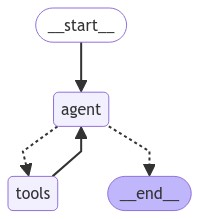

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # 這需要一些額外的依賴，是可選的
    pass

### 步驟六、系統使用示範

讓我們通過幾個具體的使用場景來展示這個系統的功能：


#### 場景 1：添加喜愛的食物


In [ ]:
from langchain_core.messages import HumanMessage

user_to_snacks.clear()  # 清除狀態

print(f"執行前的用戶資訊：{user_to_snacks}")

inputs = {"messages": [HumanMessage(content="我最喜歡的台灣小吃是臭豆腐和珍珠奶茶")]}
for output in app.stream(inputs, {"configurable": {"user_id": "123"}}):
    for key, value in output.items():
        print(f"'{key}' 節點的輸出：")
        print("---")
        print(value)
    print("\n---\n")

print(f"執行後的用戶資訊：{user_to_snacks}")

執行前的用戶資訊：{}
'agent' 節點的輸出：
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_PMgl4eDIhBv8wdwVXtE7v40l', 'function': {'arguments': '{"snacks":["臭豆腐","珍珠奶茶"]}', 'name': 'update_favorite_snacks'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 32, 'prompt_tokens': 183, 'total_tokens': 215}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-d0ce94d5-461f-4087-bd2b-9d48c07e4c85-0', tool_calls=[{'name': 'update_favorite_snacks', 'args': {'snacks': ['臭豆腐', '珍珠奶茶']}, 'id': 'call_PMgl4eDIhBv8wdwVXtE7v40l', 'type': 'tool_call'}], usage_metadata={'input_tokens': 183, 'output_tokens': 32, 'total_tokens': 215})]}

---

'tools' 節點的輸出：
---
{'messages': [ToolMessage(content='null', name='update_favorite_snacks', tool_call_id='call_PMgl4eDIhBv8wdwVXtE7v40l')]}

---

'agent' 節點的輸出：
---
{'messages': [AIMessage(content='我已經更新您最喜歡的台灣小吃清單，您的選擇是臭豆腐和珍珠奶茶

#### 場景 2：查詢喜愛的小吃

In [ ]:
print(f"執行前的用戶資訊：{user_to_snacks}")

inputs = {"messages": [HumanMessage(content="我最喜歡的小事是什麼？")]}
for output in app.stream(inputs, {"configurable": {"user_id": "123"}}):
    for key, value in output.items():
        print(f"'{key}' 節點的輸出：")
        print("---")
        print(value)
    print("\n---\n")

print(f"執行後的用戶信息：{user_to_snacks}")

執行前的用戶資訊：{'123': ['臭豆腐', '珍珠奶茶']}
'agent' 節點的輸出：
---
{'messages': [AIMessage(content='抱歉，我無法回答你最喜歡的小事是什麼，因為我不知道你的個人喜好。如果你想要分享或討論你的興趣或喜好，請隨時告訴我！我很樂意聽取並與你交流。', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 97, 'prompt_tokens': 169, 'total_tokens': 266}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'stop', 'logprobs': None}, id='run-8de25984-2c16-4e7a-aaf9-45b97028ff0f-0', usage_metadata={'input_tokens': 169, 'output_tokens': 97, 'total_tokens': 266})]}

---

執行後的用戶信息：{'123': ['臭豆腐', '珍珠奶茶']}


#### 場景 3：刪除喜愛的小吃

In [ ]:
print(f"執行前的用戶信息：{user_to_snacks}")

inputs = {
    "messages": [
        HumanMessage(content="請忘記我告訴你的關於我最喜歡的小吃資訊")
    ]
}
for output in app.stream(inputs, {"configurable": {"user_id": "123"}}):
    for key, value in output.items():
        print(f"'{key}' 節點的輸出：")
        print("---")
        print(value)
    print("\n---\n")

print(f"執行後的用戶信息：{user_to_snacks}")

運行前的用戶信息：{'123': ['臭豆腐', '珍珠奶茶']}
'agent' 節點的輸出：
---
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_uzCDv5QUJzgXOszx05aXPRBp', 'function': {'arguments': '{}', 'name': 'delete_favorite_snacks'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 183, 'total_tokens': 195}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-947f4f00-6b65-498c-b40d-014e376975f5-0', tool_calls=[{'name': 'delete_favorite_snacks', 'args': {}, 'id': 'call_uzCDv5QUJzgXOszx05aXPRBp', 'type': 'tool_call'}], usage_metadata={'input_tokens': 183, 'output_tokens': 12, 'total_tokens': 195})]}

---

'tools' 節點的輸出：
---
{'messages': [ToolMessage(content='null', name='delete_favorite_snacks', tool_call_id='call_uzCDv5QUJzgXOszx05aXPRBp')]}

---

'agent' 節點的輸出：
---
{'messages': [AIMessage(content='好的，我已經忘記了關於您最喜歡的小吃的資訊。如果您有其他需求或想跟我分享其他資訊，請隨時告訴我！', addit

### 最佳實踐
通過這個案例，我們展示了如何使用 LangChain Runnable 接口來安全地傳遞運行時信息給工具。這種方法不僅保證了系統的安全性，還提高了代碼的靈活性和可維護性。
以下是一些值得注意的最佳實踐：

- 明確區分 LLM 可控制和不可控制的參數
- 使用 RunnableConfig 來傳遞敏感或動態的運行時信息
- 設計清晰的工具接口，使其易於理解和使用
- 適當使用錯誤處理和日誌記錄，以便於調試和監控
- 定期審查和更新安全策略，確保系統始終處於最佳狀態


# 總結

通過深入探討 LangGraph 中的工具呼叫機制，我們不僅了解了其強大的功能，還洞察了 AI 系統設計的關鍵原則。Tool Node 的實現展示了如何將複雜的 AI 互動流程模塊化，使得開發高度智能和可擴展的對話系統成為可能。
在實際應用中，開發者可以基於這些基礎概念，構建更加複雜和強大的 AI 系統。無論是客戶服務、智能家居控制，還是專業領域的決策支持系統，工具呼叫都為 AI 的實際應用開闢了廣闊的前景。

# X. 參考資料

閱讀順序：

3. LangGRaph Tools Node: https://github.com/langchain-ai/langgraph/blob/main/examples/tool-calling.ipynb
  - 官方文件看到不知道的物品就找這頁：https://langchain-ai.github.io/langgraph/reference/prebuilt/#create_react_agent
4. Handle Tools node errors:https://github.com/langchain-ai/langgraph/blob/main/examples/tool-calling-errors.ipynb
4. LangGraph Tool_calling : https://langchain-ai.github.io/langgraph/how-tos/pass-run-time-values-to-tools/
4. Too_Calling Common Agentic Patterns: https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/#tool-calling

4. LangGraph Agent-executor :https://github.com/langchain-ai/langgraph/tree/main/examples/chat_agent_executor_with_function_calling
